In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
import pickle
from xgboost import XGBRegressor

In [2]:
myPath = os.path.abspath(os.getcwd())
file_path = myPath + '/mobilbekas.csv'

df = pd.read_csv(file_path)
df.head()

,Harga,Lokasi,Penjual,Merek,Model,Varian,Tahun,Jarak tempuh,Tipe bahan bakar,Warna,Transmisi,Tipe bodi,Kapasitas mesin,Tipe Penjual,Sistem Penggerak,Nama Bursa Mobil
0,155000792,"Ngaliyan, Semarang Kota, Jawa Tengah",Tegar Ranisdya,BMW,Serie 3,320i Business Edition,2006,85.000-90.000 km,Bensin,Hitam,Automatic,Sedan,>1.500 - 2.000 cc,Individu,NaN,NaN
1,56000000,"Medan Johor, Medan Kota, Sumatra Utara",Anda Syahwilhanto,Hyundai,Getz,Lain-lain,2005,0-5.000 km,Bensin,Biru,Manual,Hatchback,>1.000 - 1.500 cc,Individu,Front Wheel Drive (FWD),NaN
2,120000000,"Ilir Timur I, Palembang Kota, Sumatra Selatan",alvianistm,Isuzu,Grand touring,Lain-lain,2004,10.000-15.000 km,Diesel,Silver,Manual,NaN,NaN,Individu,NaN,NaN
3,169000000,"Balerejo, Madiun Kab., Jawa Timur",PUSAT MOBIL BEKAS SIDOARJO,Isuzu,Grand touring,Lain-lain,2010,100.000-105.000 km,Diesel,Coklat,Manual,Minibus,>2.000 - 3.000 cc,Diler,NaN,NaN
4,120000000,"Kemayoran, Jakarta Pusat, Jakarta D.K.I.",Kristian,Proton,Lain-lain,Lain-lain,2010,75.000-80.000 km,Bensin,Oranye,Manual,Pick-up,>1.500 - 2.000 cc,NaN,Rear Wheel Drive (RWD),Pasar Mobil Kemayoran


In [3]:
df.shape

(14657, 16)

In [4]:
df.columns

Index(['Harga', 'Lokasi', 'Penjual', 'Merek', 'Model', 'Varian', 'Tahun',
       'Jarak tempuh', 'Tipe bahan bakar', 'Warna', 'Transmisi', 'Tipe bodi',
       'Kapasitas mesin', 'Tipe Penjual', 'Sistem Penggerak',
       'Nama Bursa Mobil'],
      dtype='object')

In [5]:
def preprocessing():
    df['Harga (juta)'] = df['Harga'].apply(lambda x: x/1_000_000)
    df['jarak_tempuh_max'] = df['Jarak tempuh'].str.replace('.', '').str.replace(' km', '').str.split('-').str[1].to_list()
    df['jarak_tempuh_max'] = df['jarak_tempuh_max'].astype(float)
    df['Kota'] = df['Lokasi'].str.split(',').str[1].str.replace(' Kota', '').str.replace(' Kab.', '')
    df['Provinsi'] = df['Lokasi'].str.split(',').str[2]
    df['Tahun'] = df['Tahun'].str.replace('<1986', '1985').astype(int)
    df['Kapasitas mesin'] = df['Kapasitas mesin'].str.replace('>', '').str.replace('<', '').str.split().str[-2].str.replace('.', '').astype(float)
    df.drop(columns=['Harga', 'Jarak tempuh', 'Lokasi', 'Penjual', 'Nama Bursa Mobil', 'Tipe Penjual', 'Sistem Penggerak'], axis=1, inplace=True)

In [6]:
preprocessing()

Hanya menggunakan data mobil dengan harga dibawah 1 Milyar rupiah. Dikarenakan memprediksi diatas harga tersebut tidak praktikal dan data yang dimiliki kurang.

In [7]:
under_1bil = df[df['Harga (juta)'] <= 1000].copy()

In [8]:
under_1bil.head()

,Merek,Model,Varian,Tahun,Tipe bahan bakar,Warna,Transmisi,Tipe bodi,Kapasitas mesin,Harga (juta),jarak_tempuh_max,Kota,Provinsi
0,BMW,Serie 3,320i Business Edition,2006,Bensin,Hitam,Automatic,Sedan,2000.0,155.000792,90000.0,Semarang,Jawa Tengah
1,Hyundai,Getz,Lain-lain,2005,Bensin,Biru,Manual,Hatchback,1500.0,56.000000,5000.0,Medan,Sumatra Utara
2,Isuzu,Grand touring,Lain-lain,2004,Diesel,Silver,Manual,NaN,NaN,120.000000,15000.0,Palembang,Sumatra Selatan
3,Isuzu,Grand touring,Lain-lain,2010,Diesel,Coklat,Manual,Minibus,3000.0,169.000000,105000.0,Madiun,Jawa Timur
4,Proton,Lain-lain,Lain-lain,2010,Bensin,Oranye,Manual,Pick-up,2000.0,120.000000,80000.0,Jakarta Pusat,Jakarta D.K.I.


In [9]:
under_1bil.describe()

,Tahun,Kapasitas mesin,Harga (juta),jarak_tempuh_max
count,14173.000000,12473.000000,14173.000000,13988.000000
mean,2009.687716,2060.971699,178.494918,75252.001716
std,7.554608,670.161550,174.217551,53532.794739
min,1985.000000,1000.000000,6.000000,5000.000000
25%,2007.000000,1500.000000,79.000000,35000.000000
50%,2012.000000,2000.000000,120.000000,65000.000000
75%,2015.000000,3000.000000,200.000000,105000.000000
max,2019.000000,3000.000000,1000.000000,300000.000000


In [10]:
under_1bil_cat = under_1bil.select_dtypes('object')
under_1bil_cat.describe()

,Merek,Model,Varian,Tipe bahan bakar,Warna,Transmisi,Tipe bodi,Kota,Provinsi
count,14173,14173,13489,14173,14173,14173,12117,14173,14173
unique,54,441,724,4,14,3,18,251,30
top,Honda,Lain-lain,Lain-lain,Bensin,Hitam,Manual,Sedan,Jakarta Selatan,Jakarta D.K.I.
freq,980,489,3180,11886,3815,6482,2410,1298,4106


In [11]:
under_1bil.isnull().sum()

Merek                  0
Model                  0
Varian               684
Tahun                  0
Tipe bahan bakar       0
Warna                  0
Transmisi              0
Tipe bodi           2056
Kapasitas mesin     1700
Harga (juta)           0
jarak_tempuh_max     185
Kota                   0
Provinsi               0
dtype: int64

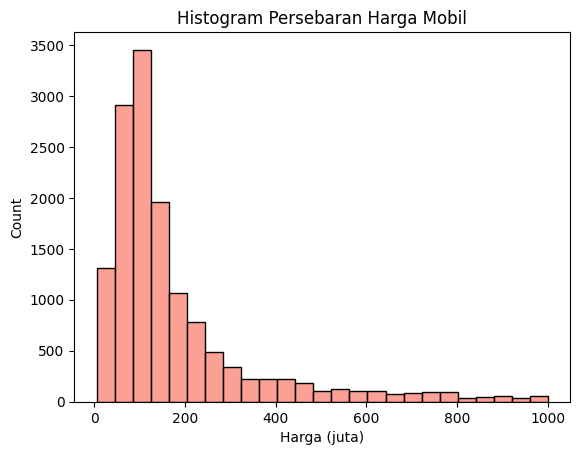

In [12]:
sns.histplot(under_1bil['Harga (juta)'], color='Salmon', bins=25)
plt.title('Histogram Persebaran Harga Mobil')
plt.show()

Kebanyakan data mobil berada di angka sekitar 100 juta

In [13]:
under_1bil['Merek'].value_counts().index[:10]

Index(['Honda', 'Toyota', 'Daihatsu', 'Suzuki', 'Mazda', 'Mitsubishi',
       'Nissan', 'BMW', 'Mercedes-Benz', 'Chevrolet'],
      dtype='object', name='Merek')

In [14]:
under_1bil['Merek'].value_counts().index[:10]

Index(['Honda', 'Toyota', 'Daihatsu', 'Suzuki', 'Mazda', 'Mitsubishi',
       'Nissan', 'BMW', 'Mercedes-Benz', 'Chevrolet'],
      dtype='object', name='Merek')

C:\Users\nabil\AppData\Local\Temp\ipykernel_3068\2410875428.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=under_1bil, y='Merek', order=under_1bil['Merek'].value_counts().index[:25], palette=palette)
C:\Users\nabil\AppData\Local\Temp\ipykernel_3068\2410875428.py:5: UserWarning: The palette list has more values (54) than needed (25), which may not be intended.
  sns.countplot(data=under_1bil, y='Merek', order=under_1bil['Merek'].value_counts().index[:25], palette=palette)


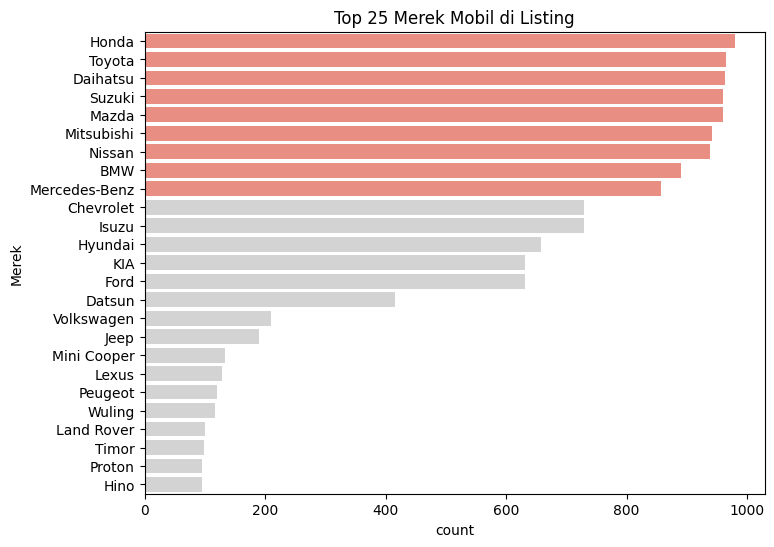

In [15]:
top_9 = under_1bil['Merek'].value_counts().index[:9]
palette = ['Salmon' if x in top_9 else '#D3D3D3' for x in under_1bil['Merek'].value_counts().index[:]]

plt.figure(figsize=(8, 6))
sns.countplot(data=under_1bil, y='Merek', order=under_1bil['Merek'].value_counts().index[:25], palette=palette)
plt.title('Top 25 Merek Mobil di Listing')
plt.show()

Honda, Toyota, Daihatsu, Suzuki, Mazda, Mitshubishi, Nissan, dan BMW memiliki market yang besar pada penjual belian mobil bekas.

C:\Users\nabil\AppData\Local\Temp\ipykernel_3068\2595250835.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=under_1bil, y='Model', order=under_1bil['Model'].value_counts().index[1:26], palette=palette)
C:\Users\nabil\AppData\Local\Temp\ipykernel_3068\2595250835.py:5: UserWarning: The palette list has more values (441) than needed (25), which may not be intended.
  sns.countplot(data=under_1bil, y='Model', order=under_1bil['Model'].value_counts().index[1:26], palette=palette)


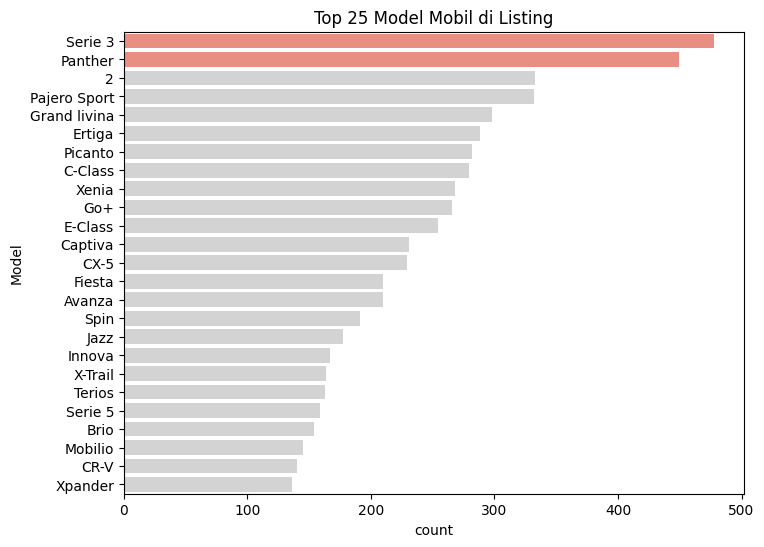

In [16]:
top_2 = under_1bil['Model'].value_counts().index[:2]
palette = ['Salmon' if x in top_2 else '#D3D3D3' for x in under_1bil['Model'].value_counts().index[:]]

plt.figure(figsize=(8, 6))
sns.countplot(data=under_1bil, y='Model', order=under_1bil['Model'].value_counts().index[1:26], palette=palette)
plt.title('Top 25 Model Mobil di Listing')
plt.show()

C:\Users\nabil\AppData\Local\Temp\ipykernel_3068\4139867206.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=under_1bil, y='Varian', order=under_1bil['Varian'].value_counts().index[1:26], palette=palette)
C:\Users\nabil\AppData\Local\Temp\ipykernel_3068\4139867206.py:5: UserWarning: The palette list has more values (724) than needed (25), which may not be intended.
  sns.countplot(data=under_1bil, y='Varian', order=under_1bil['Varian'].value_counts().index[1:26], palette=palette)


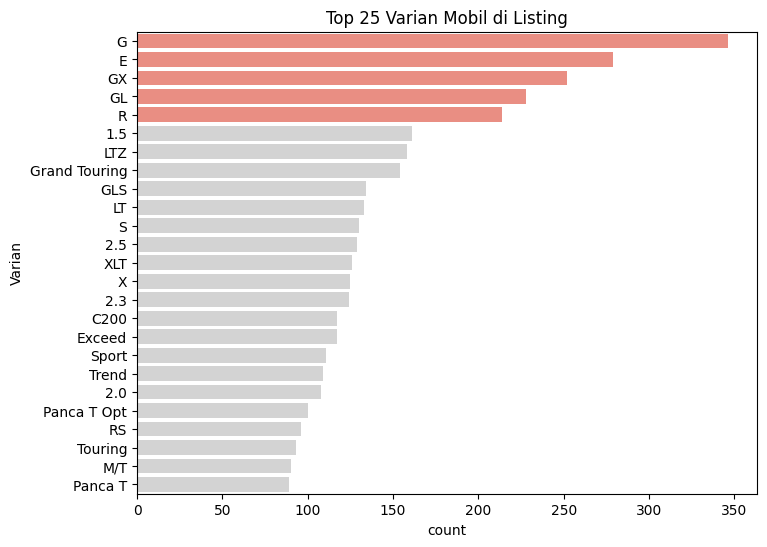

In [17]:
top_2 = under_1bil['Varian'].value_counts().index[:5]
palette = ['Salmon' if x in top_2 else '#D3D3D3' for x in under_1bil['Varian'].value_counts().index[:]]

plt.figure(figsize=(8, 6))
sns.countplot(data=under_1bil, y='Varian', order=under_1bil['Varian'].value_counts().index[1:26], palette=palette)
plt.title('Top 25 Varian Mobil di Listing')
plt.show()

BMW Serie 3 dan Isuzu Panther mendominasi pasar jual beli mobil bekas dari segi model.

C:\Users\nabil\AppData\Local\Temp\ipykernel_3068\3250090885.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=under_1bil, y='Tahun', order=under_1bil['Tahun'].value_counts().index[1:26], palette=palette)
C:\Users\nabil\AppData\Local\Temp\ipykernel_3068\3250090885.py:5: UserWarning: The palette list has more values (35) than needed (25), which may not be intended.
  sns.countplot(data=under_1bil, y='Tahun', order=under_1bil['Tahun'].value_counts().index[1:26], palette=palette)


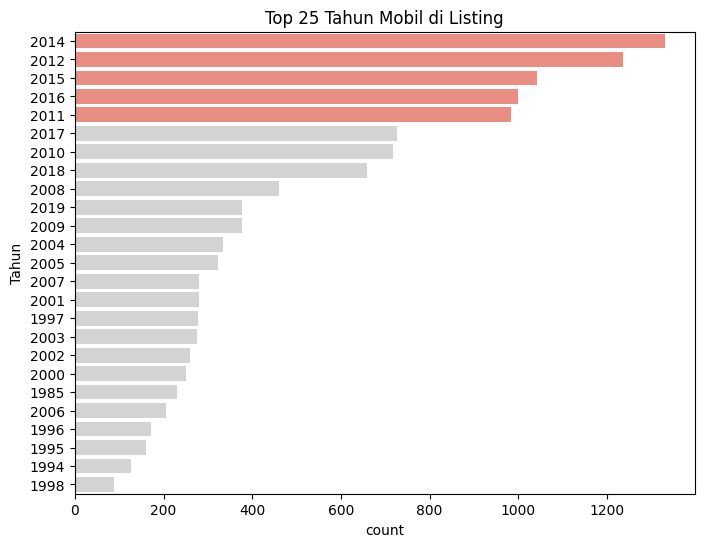

In [18]:
top_5 = under_1bil['Tahun'].value_counts().index[:5]
palette = ['Salmon' if x in top_5 else '#D3D3D3' for x in under_1bil['Tahun'].value_counts().index[:]]

plt.figure(figsize=(8, 6))
sns.countplot(data=under_1bil, y='Tahun', order=under_1bil['Tahun'].value_counts().index[1:26], palette=palette)
plt.title('Top 25 Tahun Mobil di Listing')
plt.show()

Rata-rata orang menjual mobilnya kembali setelah 3-8 tahun pemakaian.

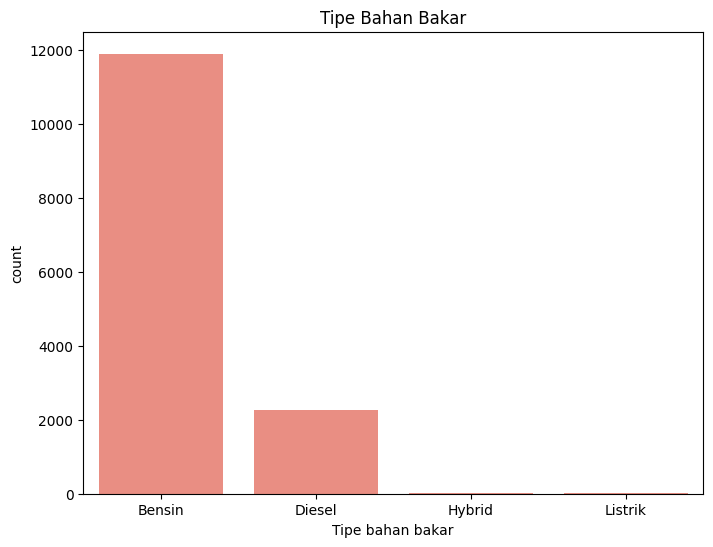

In [19]:
plt.figure(figsize=(8, 6))
sns.countplot(data=under_1bil, x='Tipe bahan bakar', order=under_1bil['Tipe bahan bakar'].value_counts().index, color='Salmon')
plt.title('Tipe Bahan Bakar')
plt.show()

Mobil bensin dan diesel mendominasi pasar jual beli mobil bekas pada tahun 2019.

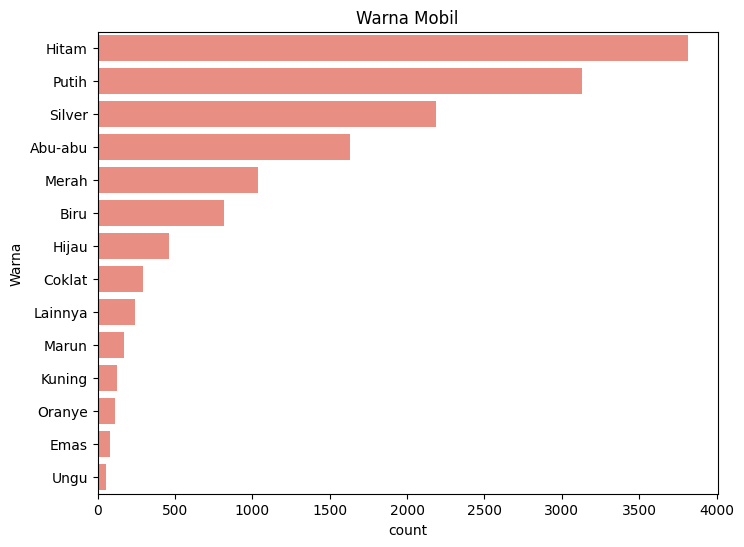

In [20]:
plt.figure(figsize=(8, 6))
sns.countplot(data=under_1bil, y='Warna', order=under_1bil['Warna'].value_counts().index, color='Salmon')
plt.title('Warna Mobil')
plt.show()

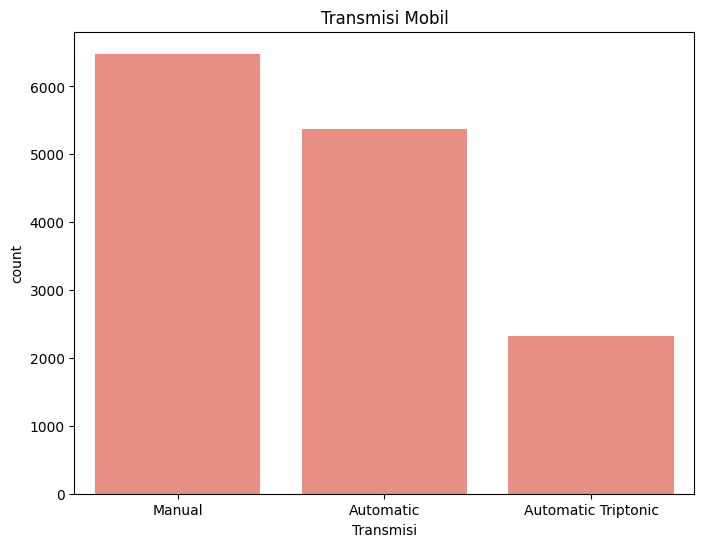

In [21]:
plt.figure(figsize=(8, 6))
sns.countplot(data=under_1bil, x='Transmisi', order=under_1bil['Transmisi'].value_counts().index, color='Salmon')
plt.title('Transmisi Mobil')
plt.show()

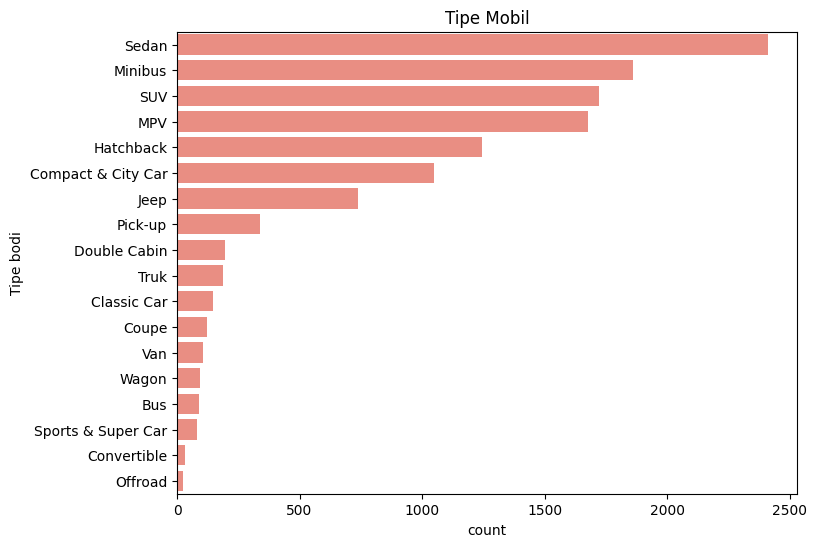

In [22]:
plt.figure(figsize=(8, 6))
sns.countplot(data=under_1bil, y='Tipe bodi', order=under_1bil['Tipe bodi'].value_counts().index, color='Salmon')
plt.title('Tipe Mobil')
plt.show()

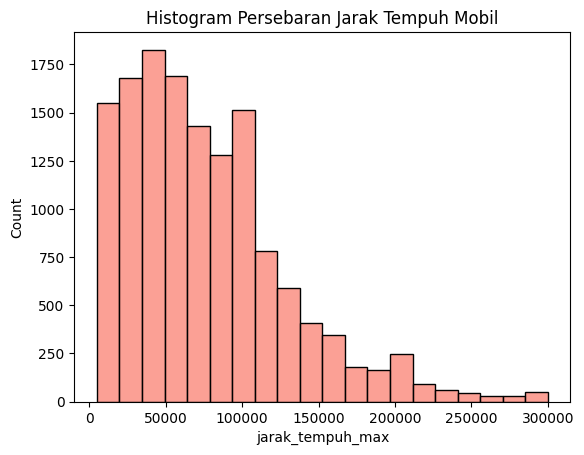

In [23]:
sns.histplot(under_1bil['jarak_tempuh_max'], color='Salmon', bins=20)
plt.title('Histogram Persebaran Jarak Tempuh Mobil')
plt.show()

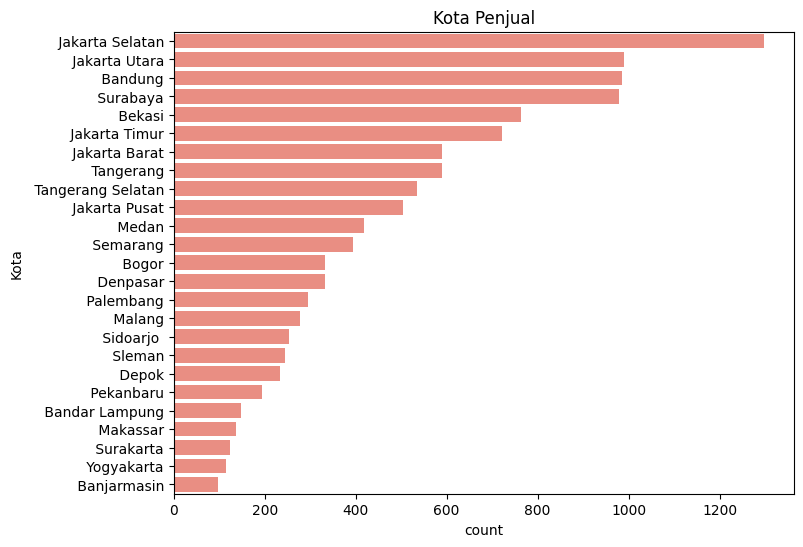

In [24]:
plt.figure(figsize=(8, 6))
sns.countplot(data=under_1bil, y='Kota', order=under_1bil['Kota'].value_counts().index[:25], color='Salmon')
plt.title('Kota Penjual')
plt.show()

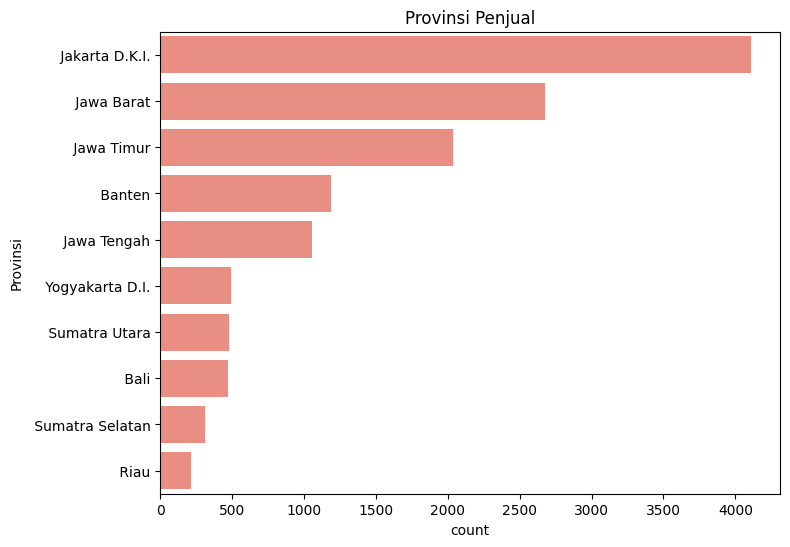

In [25]:
plt.figure(figsize=(8, 6))
sns.countplot(data=under_1bil, y='Provinsi', order=under_1bil['Provinsi'].value_counts().index[:10], color='Salmon')
plt.title('Provinsi Penjual')
plt.show()

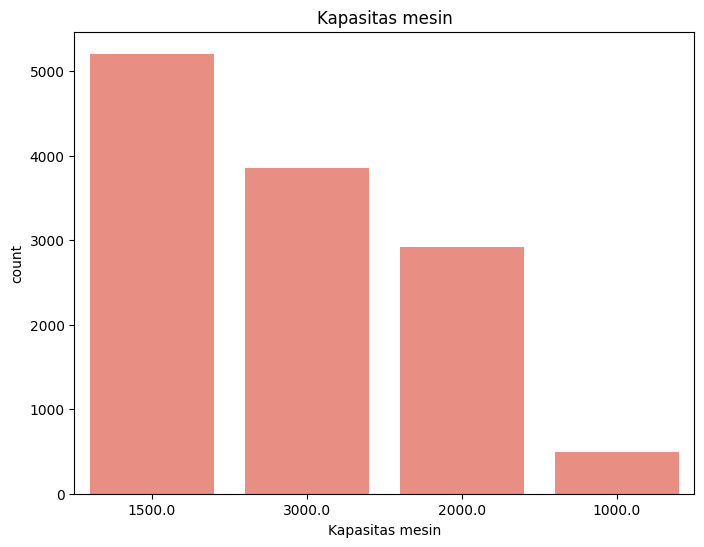

In [26]:
plt.figure(figsize=(8, 6))
sns.countplot(data=under_1bil, x='Kapasitas mesin', order=under_1bil['Kapasitas mesin'].value_counts().index[:10], color='Salmon')
plt.title('Kapasitas mesin')
plt.show()

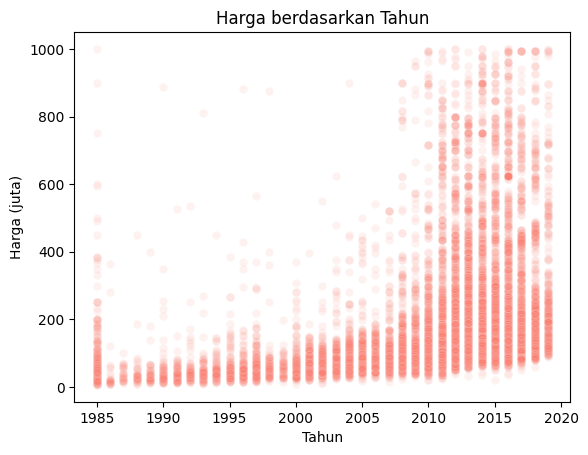

In [27]:
sns.scatterplot(data=under_1bil, x='Tahun', y='Harga (juta)', alpha=0.1, color='Salmon')
plt.title('Harga berdasarkan Tahun')
plt.show()

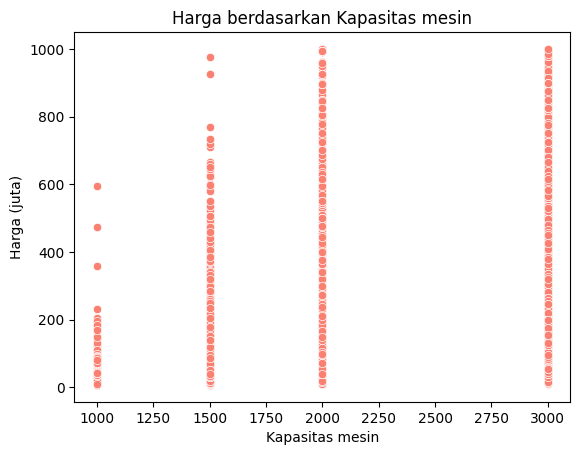

In [28]:
sns.scatterplot(data=under_1bil, x='Kapasitas mesin', y='Harga (juta)', color='Salmon')
plt.title('Harga berdasarkan Kapasitas mesin')
plt.show()

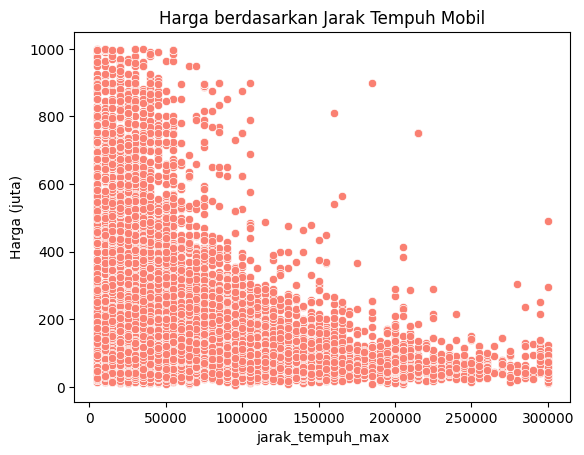

In [29]:
sns.scatterplot(data=under_1bil, x='jarak_tempuh_max', y='Harga (juta)', color='Salmon')
plt.title('Harga berdasarkan Jarak Tempuh Mobil')
plt.show()

In [30]:
under_1bil.isnull().sum()

Merek                  0
Model                  0
Varian               684
Tahun                  0
Tipe bahan bakar       0
Warna                  0
Transmisi              0
Tipe bodi           2056
Kapasitas mesin     1700
Harga (juta)           0
jarak_tempuh_max     185
Kota                   0
Provinsi               0
dtype: int64

In [31]:
X = under_1bil.drop(columns='Harga (juta)')
y = under_1bil['Harga (juta)']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
num_features = ['Kapasitas mesin', 'Tahun', 'jarak_tempuh_max']
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaled', StandardScaler())
])

cat_features = ['Merek', 'Model', 'Varian', 'Tipe bahan bakar', 'Warna', 'Transmisi', 'Tipe bodi', 'Kapasitas mesin', 'Kota', 'Provinsi']
cat_transformer = Pipeline([
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('imputer', KNNImputer(n_neighbors=5)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [34]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaled',
                                                                   StandardScaler())]),
                                                  ['Kapasitas mesin', 'Tahun',
                                                   'jarak_tempuh_max']),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinal_encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('imputer',
                                                                   KNNImputer()),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Merek', 'Model', 'Varian',
                                                   'Tipe bahan bakar', 'Warna',
                                                   'Transmisi', 'Tipe bodi',
                                                   'Kapasitas mesin', 'Kota',
                                                   'Provinsi'])])),
                ('regressor', LinearRegression())])

In [35]:
y_pred = pipeline.predict(X_test)

In [36]:
X_test.head(5)

,Merek,Model,Varian,Tahun,Tipe bahan bakar,Warna,Transmisi,Tipe bodi,Kapasitas mesin,jarak_tempuh_max,Kota,Provinsi
2387,Mitsubishi,Mirage,SPORT,2015,Bensin,Putih,Automatic,Compact & City Car,1500.0,55000.0,Kulon Progo,Yogyakarta D.I.
9405,Mazda,2,R,2015,Bensin,Merah,Automatic,Hatchback,1500.0,80000.0,Jakarta Utara,Jakarta D.K.I.
5342,Hino,Dutro,Truck,2012,Diesel,Oranye,Manual,Truk,3000.0,95000.0,Jakarta Timur,Jakarta D.K.I.
3311,Ford,Fiesta,Style,2013,Bensin,Putih,Automatic,NaN,NaN,115000.0,Denpasar,Bali
13496,Datsun,Go+,Panca T Style,2016,Bensin,Putih,Manual,Compact & City Car,1500.0,55000.0,Bogor,Jawa Barat


In [37]:
pipeline.predict(X_test.head(5))

array([ 94.66940685, 172.12167387, 174.68586696, 141.96314485,
        80.81218012])

In [38]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 78.68836606364493
MAE: 41.94713296553069


In [39]:
filename = 'lr_base_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(pipeline, file)

In [40]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor())
])

In [41]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaled',
                                                                   StandardScaler())]),
                                                  ['Kapasitas mesin', 'Tahun',
                                                   'jarak_tempuh_max']),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinal_encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('imputer',
                                                                   KNNImputer()),
                                                                  ('one...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [42]:
y_pred = pipeline.predict(X_test)

In [43]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 60.85475124381391
MAE: 32.419580076916176


In [44]:
pipeline.predict(X_test.head(5))

array([121.256744, 139.58879 , 225.72018 , 107.458145,  83.609695],
      dtype=float32)

In [45]:
filename = 'xgb_base_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(pipeline, file)

In [46]:
param_dist = {
    'regressor__learning_rate': [0.1, 0.01, 0.001],
    'regressor__max_depth': [3, 5, 7, 9, 11],
    'regressor__n_estimators': [50, 100, 150, 200, 250],
    'regressor__gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'regressor__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'regressor__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'regressor__reg_alpha': [0.0, 0.01, 0.1, 0.5, 1.0],
    'regressor__reg_lambda': [0.0, 0.01, 0.1, 0.5, 1.0]
}

In [47]:
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=300, scoring='neg_mean_absolute_error', cv=3, random_state=42, verbose=10, n_jobs=-1)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaled',
                                                                                                StandardScaler())]),
                                                                               ['Kapasitas '
                                                                                'mesin',
                                                                                'Tahun',
                                                                                'jarak_tempuh_max']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('ordinal_encoder',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unknown_value...
                                        'regressor__gamma': [0, 0.1, 0.2, 0.3,
                                                             0.4],
                                        'regressor__learning_rate': [0.1, 0.01,
                                                                     0.001],
                                        'regressor__max_depth': [3, 5, 7, 9,
                                                                 11],
                                        'regressor__n_estimators': [50, 100,
                                                                    150, 200,
                                                                    250],
                                        'regressor__reg_alpha': [0.0, 0.01, 0.1,
                                                                 0.5, 1.0],
                                        'regressor__reg_lambda': [0.0, 0.01,
                                                                  0.1, 0.5,
                                                                  1.0],
                                        'regressor__subsample': [0.6, 0.7, 0.8,
                                                                 0.9, 1.0]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=10)

In [48]:
print("Best parameters found by random search:")
print(random_search.best_params_)
print("Best cross-validation score (MAE):")
print(-random_search.best_score_)

Best parameters found by random search:
{'regressor__subsample': 0.9, 'regressor__reg_lambda': 0.1, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 200, 'regressor__max_depth': 11, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0.4, 'regressor__colsample_bytree': 0.7}
Best cross-validation score (MAE):
27.925684819425925


In [49]:
filename = 'xgb_best_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(random_search, file)

In [50]:
under_1bil.head()

,Merek,Model,Varian,Tahun,Tipe bahan bakar,Warna,Transmisi,Tipe bodi,Kapasitas mesin,Harga (juta),jarak_tempuh_max,Kota,Provinsi
0,BMW,Serie 3,320i Business Edition,2006,Bensin,Hitam,Automatic,Sedan,2000.0,155.000792,90000.0,Semarang,Jawa Tengah
1,Hyundai,Getz,Lain-lain,2005,Bensin,Biru,Manual,Hatchback,1500.0,56.000000,5000.0,Medan,Sumatra Utara
2,Isuzu,Grand touring,Lain-lain,2004,Diesel,Silver,Manual,NaN,NaN,120.000000,15000.0,Palembang,Sumatra Selatan
3,Isuzu,Grand touring,Lain-lain,2010,Diesel,Coklat,Manual,Minibus,3000.0,169.000000,105000.0,Madiun,Jawa Timur
4,Proton,Lain-lain,Lain-lain,2010,Bensin,Oranye,Manual,Pick-up,2000.0,120.000000,80000.0,Jakarta Pusat,Jakarta D.K.I.


In [51]:
X = under_1bil.drop(columns=['Harga (juta)', 'Tipe bahan bakar', 'Warna', 'Tipe bodi', 'Kapasitas mesin', 'Kota', 'Provinsi'])
y = under_1bil['Harga (juta)']

In [52]:
X.head()

,Merek,Model,Varian,Tahun,Transmisi,jarak_tempuh_max
0,BMW,Serie 3,320i Business Edition,2006,Automatic,90000.0
1,Hyundai,Getz,Lain-lain,2005,Manual,5000.0
2,Isuzu,Grand touring,Lain-lain,2004,Manual,15000.0
3,Isuzu,Grand touring,Lain-lain,2010,Manual,105000.0
4,Proton,Lain-lain,Lain-lain,2010,Manual,80000.0


In [53]:
X.to_csv('Final_dataset.csv', index=False)

In [54]:
num_features = ['Tahun', 'jarak_tempuh_max']
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaled', StandardScaler())
])

cat_features = ['Merek', 'Model', 'Varian', 'Transmisi']
cat_transformer = Pipeline([
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('imputer', KNNImputer(n_neighbors=5)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor())
])

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaled',
                                                                   StandardScaler())]),
                                                  ['Tahun',
                                                   'jarak_tempuh_max']),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinal_encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('imputer',
                                                                   KNNImputer()),
                                                                  ('onehot',
                                                                   OneHotEncode...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [56]:
y_pred = pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 59.267276978595724
MAE: 31.31889963567691


In [57]:
param_dist = {
    'regressor__learning_rate': [0.1, 0.01, 0.001],
    'regressor__max_depth': [3, 5, 7, 9, 11],
    'regressor__n_estimators': [50, 100, 150, 200, 250],
    'regressor__gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'regressor__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'regressor__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'regressor__reg_alpha': [0.0, 0.01, 0.1, 0.5, 1.0],
    'regressor__reg_lambda': [0.0, 0.01, 0.1, 0.5, 1.0]
}

In [58]:
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=300, scoring='neg_mean_absolute_error', cv=3, random_state=42, verbose=10, n_jobs=-1)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaled',
                                                                                                StandardScaler())]),
                                                                               ['Tahun',
                                                                                'jarak_tempuh_max']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('ordinal_encoder',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unknown_value=-1)),
                                                                                               ('imputer',
                                                                                                KN...
                                        'regressor__gamma': [0, 0.1, 0.2, 0.3,
                                                             0.4],
                                        'regressor__learning_rate': [0.1, 0.01,
                                                                     0.001],
                                        'regressor__max_depth': [3, 5, 7, 9,
                                                                 11],
                                        'regressor__n_estimators': [50, 100,
                                                                    150, 200,
                                                                    250],
                                        'regressor__reg_alpha': [0.0, 0.01, 0.1,
                                                                 0.5, 1.0],
                                        'regressor__reg_lambda': [0.0, 0.01,
                                                                  0.1, 0.5,
                                                                  1.0],
                                        'regressor__subsample': [0.6, 0.7, 0.8,
                                                                 0.9, 1.0]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=10)

In [59]:
print("Best parameters found by random search:")
print(random_search.best_params_)
print("Best cross-validation score (MAE):")
print(-random_search.best_score_)

Best parameters found by random search:
{'regressor__subsample': 1.0, 'regressor__reg_lambda': 0.0, 'regressor__reg_alpha': 0.5, 'regressor__n_estimators': 250, 'regressor__max_depth': 11, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0.3, 'regressor__colsample_bytree': 0.9}
Best cross-validation score (MAE):
27.49847431500666


In [60]:
filename = 'xgb_simple_best_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(random_search, file)

In [62]:
under_1bil = under_1bil.dropna(subset=['Varian','Tipe bodi','Kapasitas mesin','jarak_tempuh_max'])

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


X = pd.get_dummies(under_1bil[['Merek', 'Model', 'Tahun', 'jarak_tempuh_max']])
y = under_1bil['Harga (juta)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestRegressor()


model.fit(X_train, y_train)


y_pred = model.predict(X_test)


from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 25.125994129562212


In [66]:


# Mendefinisikan parameter grid untuk Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Melakukan Grid Search dengan Cross Validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Mendapatkan hyperparameter terbaik
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Melatih model dengan hyperparameter terbaik
best_model = grid_search.best_estimator_

# Memprediksi nilai
y_pred = best_model.predict(X_test)

# Menghitung Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)


Fitting 3 folds for each of 648 candidates, totalling 1944 fits
